# Edited Nearest Neighbours

The algorithms works as follows:

1) Train a KNN algorithm on the data (user defines number of neighbours, typically 3)

2) Find the 3 nearest neighbour to each observation (or the number defined by the user in 1)

3) Find the label of each of the neighbours (we know it, is the target in the dataset)

**Two undersampling strategies:**

4) **mode**: if **the majority of the neighbours** show the same label as the observation, then we keep the observation

5) **all**: if **all the neighbours** show the same label as the observation, then we keep the observation

6) Alternatively, we remove the observation of the dataset - **undersample**

7) The undersampled dataset, is the one left after removing observations


===

The algorithm removes observations which class are different from that of their neighbours. These are generally the observations difficult to classify and / or that introduce noise.

**In practice, samples of the majority class that are too similar to an observation of the minority class will be removed.**

So this is, in essence, the opposite of Condensed NN.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import EditedNearestNeighbours

## Create data

We will create data where the classes have different degrees of separateness.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [2]:
def make_data(sep):
    
    # returns arrays
    X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           weights=[0.99],
                           class_sep=sep,# how separate the classes are
                           random_state=1)
    
    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns =['varA', 'varB'])
    y = pd.Series(y)
    
    return X, y

## Undersample with Edited Nearest Neighbours

[EditedNearestNeighbours](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)

### Well separated classes

In [3]:
# create data

X, y = make_data(sep=2)

# set up edited nearest neighbour

enn = EditedNearestNeighbours(
    sampling_strategy='auto',  # undersamples only the majority class
    n_neighbors=3, # the number of neighbours to examine
    kind_sel='all',  # all neighbours need to have the same label as the observation examined
    n_jobs=4)  # I have 4 cores in my laptop

X_resampled, y_resampled = enn.fit_resample(X, y)

In [4]:
# size of original data

X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((978, 2), (978,))

The procedure removed a few observations closer to the minority class.

In [6]:
# number of minority class observations

y.value_counts()

0    983
1     17
dtype: int64

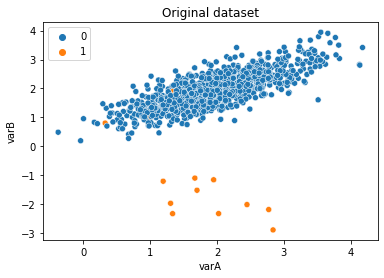

In [7]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

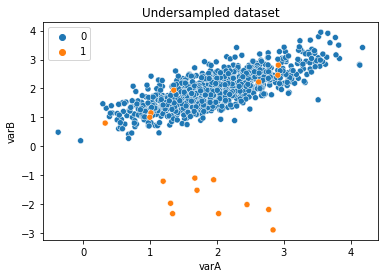

In [8]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset')
plt.show()

Note how some yellow dots can now be seen clearer, as their neighbouring observations from the majority class were removed from the data set.

Edited Nearest Neighbours removes observations from the majority class that are too similar to some of those in the minority class. 

### Partially separated classes

Let's repeat the same exercise in data where the classes are not so clearly separated. 

In [9]:
# create data
X, y = make_data(sep=0)

# set up edited nearest neighbour transformer

enn = EditedNearestNeighbours(
    sampling_strategy='auto',  # resamples the majority class
    n_neighbors=3, # the number of neighbours to examine
    kind_sel='all',  # all neighbours need to agree
    n_jobs=4)  # I have 4 cores in my laptop


X_resampled, y_resampled = enn.fit_resample(X, y)

In [10]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# undersampled data

X_resampled.shape, y_resampled.shape

((960, 2), (960,))

As the classes are not so clearly distinguished, more samples were removed from the dataset.

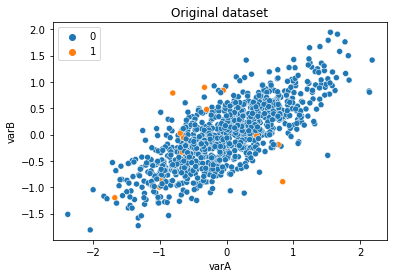

In [12]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset')
plt.show()

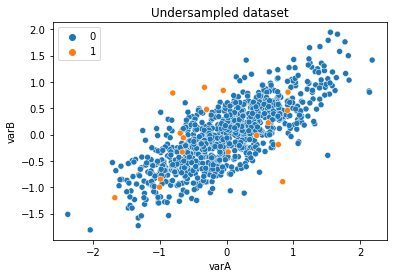

In [13]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

Notice again, that observations have been cleared from the surroundings of those of the minority class.

**HOMEWORK**

- Change the number of neighbours to exaomine
- Change the selection method from **all** to **mode**
- compare the result in terms of distribution and size of resulting dataset.

Note that if we pass an integer to the argument n_neighbors=3, 3 is the number of neighbours to examine, we will look at the 3 closest neighbours to determine if a sample is kept or removed.

If instead of an integer, you want to pass a KNN class from Scikit-learn, like the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), remember that to examine 3 neighbours, you need to train a 4 KNN as the observation will be 1 of the neighbours itself.

## Edited Nearest Neighbours

### Real data - Performance comparison

Does it work well with real datasets? 

Well, it will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [14]:
# load data
# only a few observations to speed the computaton

data = pd.read_csv('../kdd2004.csv').sample(10000, random_state=10)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
76689,36.51,31.00,0.22,-50.5,28.5,1775.5,0.74,1.66,-11.5,-87.5,...,1478.4,0.19,4.55,5.0,-127.0,1029.8,0.39,0.47,0.44,-1
61613,87.56,25.79,0.73,-24.0,6.5,2078.1,-0.61,1.00,7.5,-86.5,...,1549.9,0.30,-2.28,-17.0,-89.0,906.4,0.34,0.30,0.21,-1
14280,43.55,24.14,-2.09,-68.0,37.0,438.0,1.76,-0.02,-6.0,-55.0,...,-63.0,1.83,0.92,2.0,-46.0,182.5,-1.12,0.15,0.19,-1
61672,39.17,28.24,0.86,-13.0,-25.5,2326.5,0.94,0.04,-1.0,-81.5,...,1995.8,0.39,-4.37,-23.0,-54.0,188.8,2.80,0.55,0.47,-1
70728,88.80,22.52,0.89,5.0,-30.0,620.9,1.12,0.19,-4.0,-66.0,...,751.9,-0.22,-0.39,-4.0,-41.0,337.5,0.77,0.25,0.39,-1


In [15]:
# imbalanced target

data.target.value_counts() / len(data)

-1    0.9913
 1    0.0087
Name: target, dtype: float64

In [16]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

In [17]:
# edited nearest neighbours

enn = EditedNearestNeighbours(
    sampling_strategy='auto',  # resamples the majority class
    n_neighbors=3, # the number of neighbours to examine to remove an observation
    kind_sel='all',  # all neighbours need to agree
    n_jobs=4)  # I have 4 cores in my laptop

X_enn, y_enn = enn.fit_resample(X_train, y_train)

In [18]:
# compare shapes

X_train.shape, X_enn.shape

((7000, 74), (6954, 74))

## Plot data

Let's compare how the data looks before and after the undersampling.

Text(0.5, 1.0, 'Original data')

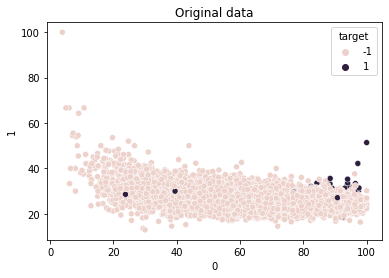

In [19]:
# original data

sns.scatterplot(data=X_train,
                x="0",
                y="1",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Edited NN data')

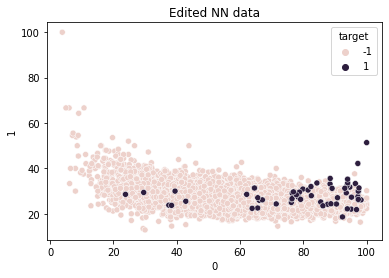

In [20]:
# enn undersampled data

sns.scatterplot(data=X_enn,
                x="0",
                y="1",
                hue=y_enn)

plt.title('Edited NN data')

Text(0.5, 1.0, 'Original data')

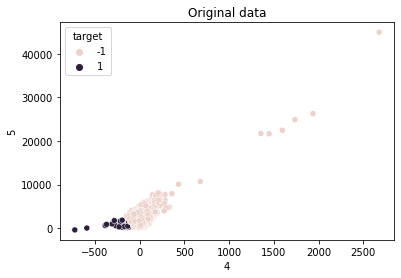

In [21]:
# original data, other set of variables

sns.scatterplot(data=X_train,
                x="4",
                y="5",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Edited NN data')

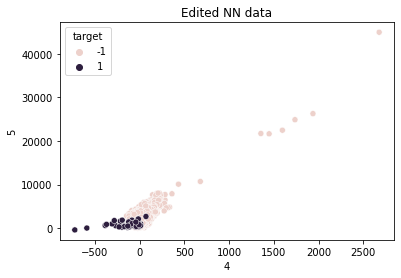

In [22]:
# enn undersampled data

sns.scatterplot(data=X_enn,
                x="4",
                y="5",
                hue=y_enn)

plt.title('Edited NN data')

## Machine learning performance comparison

Let's compare model performance with and without undersampling.

In [23]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [24]:
# evaluate performance of algorithm built
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9946325648414985
Test set
Random Forests roc-auc: 0.983555705049146


In [25]:
# evaluate performance of algorithm built
# using enn undersampled dataset

run_randomForests(X_enn,
                  X_test,
                  y_enn,
                  y_test)

Train set
Random Forests roc-auc: 0.9918528188763176
Test set
Random Forests roc-auc: 0.9811762654009543


Performance seems to decrease with this method.

**HOMEWORK**

- Change the number of neighbours and the selection method from all to mode and compare the model performance and observation distributions.